In [0]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install git+git://github.com/arviz-devs/arviz.git


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Inferencia Bayesiana aplicada a análisis de Ventas

Se requiere conocer un punto crítico en las ventas diarias logradas para uno de los clientes. 
Tenemos un conjunto de datos que contiene el número de ventas diarias (número de servicios logísticos - viajes) para el cliente Nestlé desde que inició la relación comercial.  Periodo de 26 octubre de 2017 al 15 de mayo de 2020.

Para facilitar el análisis, en el conjunto de datos, el día 26/oct/2017 se indica como día 36 (el día 1 fue cuando inició operaciones la compañía) y así hasta el día 968, que se refiere al 15 de mayo del presente año. 

In [0]:
import pandas as pd
import pylab as plt
#df = pd.read_csv('https://raw.githubusercontent.com/0234447/DataScience/master/procter.csv')
#df = pd.read_csv('https://raw.githubusercontent.com/0234447/DataScience/master/walmart.csv')
df = pd.read_csv('https://raw.githubusercontent.com/0234447/DataScience/master/nestle.csv')

df.head()

,dia,num_ventas
0,36,1
1,37,1
2,38,1
3,39,1
4,40,7


In [0]:
len (df)

933

<BarContainer object of 933 artists>

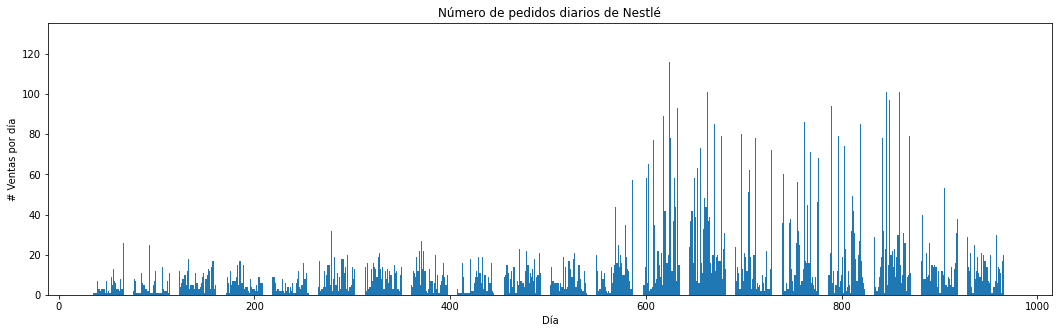

In [0]:
plt.subplots(figsize=(18,5))
plt.xlabel('Día')
plt.ylabel('# Ventas por día')
plt.title('Número de pedidos diarios de Nestlé')

plt.bar(df['dia'], df['num_ventas'].values)

Se puede visualizar un notorio incremento de ventas a partir del día 550 aprox. y a partir de ahí se llega a una base de ventas.

El análisis estará enfocado a identificar a partir de qué momento después de haberse ya consolidado al cliente, empieza una declinación de la relación. 


In [0]:
df = df[550:]

In [0]:
df.num_ventas.mean()

22.848563968668408

In [0]:
df.num_ventas.std()

24.70979291158594

<BarContainer object of 383 artists>

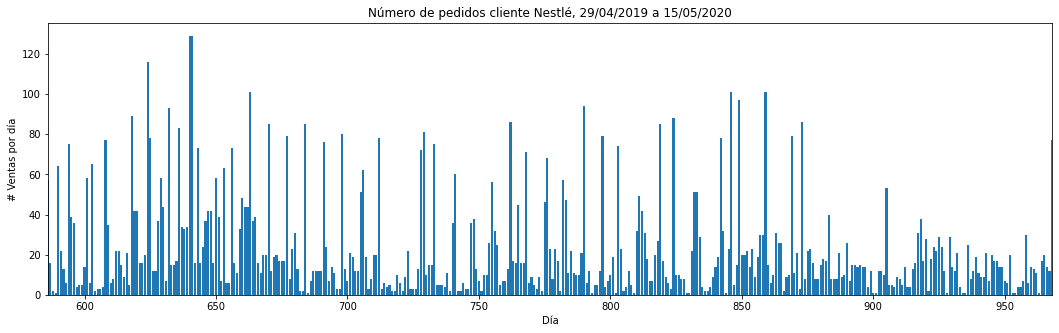

In [0]:
plt.subplots(figsize=(18,5))
plt.xlim(586, 968)
#plt.ylim(0, 86)
plt.xlabel('Día')
plt.ylabel('# Ventas por día')
plt.title('Número de pedidos cliente Nestlé, 29/04/2019 a 15/05/2020')

plt.bar(df['dia'], df['num_ventas'].values)

En el nuevo corte el promedio es 22.

Hay 3 variables a determinar en el análisis:


1.   Dia del cambio
2.   Promedio Antes del cambio.
3.   Promedio Después del cambio.



El número de viajes vendidos en un día será descrito como una variable aleatoria con distribución de Poisson. Esta distribución requiere un parámetro lambda, que es la media de las observaciones, redondeada al entero más cercano, ya que la distribución es discreta. El tiempo entre cada evento se modela con una distribución exponencial.

$\lambda = 22$

¿Cómo se ven estas distribuciones?

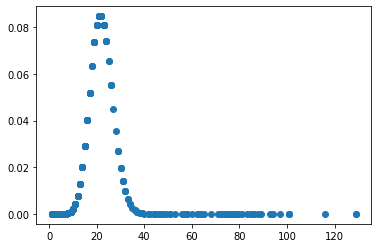

In [0]:
from scipy.stats import poisson
from scipy.stats import expon
import numpy as np

mu = 22
fig, ax = plt.subplots(1,1)
x = df['num_ventas'].values
ax.plot(x, poisson.pmf(x, mu), 'o')

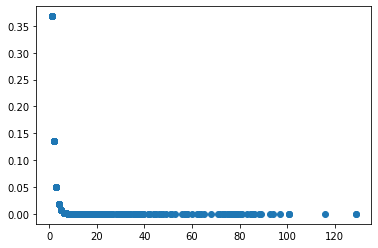

In [0]:
fig, ax = plt.subplots(1,1)
ax.plot(x, expon.pdf(x), 'o')

Tenemos un parámetro $\mu_1$ antes del cambio y otro $\mu_2$ despues del cambio.

# Definición de Priors 


1.   El parámetro mu, lo muestreamos en una distribución exponencial. Hiperparámetro
$\mu \sim \text{Exp}(\alpha)$

[Distribución exponencial ](https://en.wikipedia.org/wiki/Exponential_distribution)


2.   Día del cambio de comportamiento. 
Es un dia entre 586 y 968, lo cual lo hace una variable uniforme.
[Distribución variable uniforme ](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous))


In [0]:
import pymc3 as pm
import theano.tensor as tt
data = df.num_ventas.values  #data son las observaciones de ventas
data.mean()

22.848563968668408

In [0]:
len(data) #383 observaciones

383

In [0]:
n_count_data = len(data)
with pm.Model() as model:
   # Priors para los parámetros desconocidos del modelo 
  alpha = 1.0/(count_data.mean())

  tau_1 = pm.DiscreteUniform("tau", lower = 0, upper=n_count_data-1)

  mu_1 = pm.Exponential("mu_1", alpha)
  mu_2 = pm.Exponential("mu_2", alpha)


In [0]:
with model: 
  idx = np.arange(n_count_data)  #idx es un arreglo de longitud 383
  
  # Valor esperado del resultado
  #Stochastic variable - represents the data likelihood of the model. should not be changed by any fitting algorithm applied to the model.
  mu_ = pm.math.switch  (tau_1 > idx, mu_1, mu_2) 
# aqui definimos el cambio de mu_1 y mu_2

In [0]:
with model:

  #los datos observados se modelan en distribución de Poisson 
  #como parémtro, el tensor temporal mu_
  observation = pm.Poisson("obs", mu_, observed = data)   #es un tensor 

In [0]:
with model:
  step = pm.Metropolis() #Standar sampling algorithm: adaptative Metropolis-Hastings
  #PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. 
  #trace = pm.sample(100000, tune = 50000, step = step)

  trace = pm.sample(200000, tune = 100000,  step = step)
  # The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a Trace object containing the samples collected,
  # in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. 
  #The first dimension of the array is the sampling index and the later dimensions match the shape of the variable

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [mu_2]
>Metropolis: [mu_1]
>Metropolis: [tau]


Sampling 2 chains for 100_000 tune and 200_000 draw iterations (200_000 + 400_000 draws total) took 257 seconds.
The number of effective samples is smaller than 10% for some parameters.


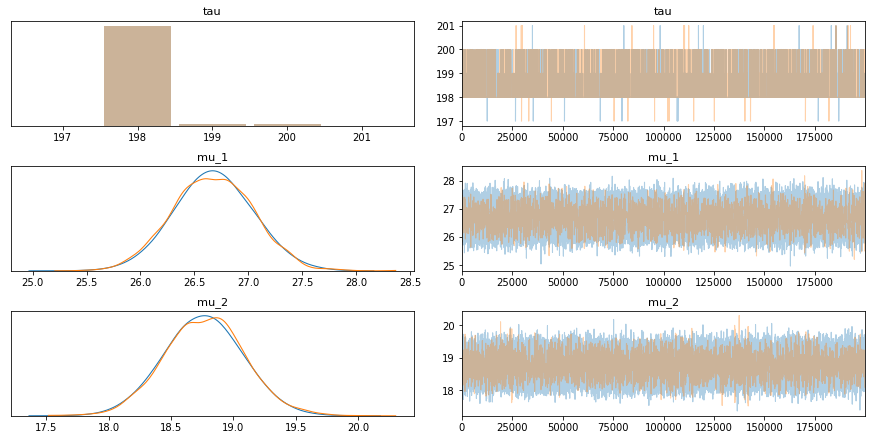

In [0]:
pm.plot_trace(trace);


La columna izquierda es un histograma 
La columna derecha muestra el muestreo realizado durante el proceso en orden secuencial.

In [0]:
pm.summary(trace).round()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,198.0,0.0,198.0,198.0,0.0,0.0,31817.0,31817.0,31927.0,32504.0,1.0
mu_1,27.0,0.0,26.0,27.0,0.0,0.0,8950.0,8950.0,8973.0,8931.0,1.0
mu_2,19.0,0.0,18.0,19.0,0.0,0.0,10377.0,10375.0,10347.0,10264.0,1.0


Estadísticos generados indican que el día de corte es el 198, es decir 13 de noviembre del 2019. Con un promedio inicial de 27 y un promedio final de 19.

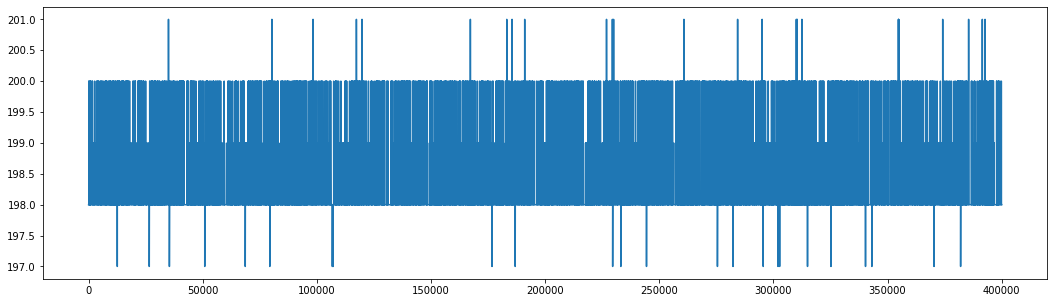

In [0]:
plt.subplots(figsize=(18,5))
plt.plot(trace['tau'])

In [0]:
mu_1_samples = trace['mu_1']
mu_2_samples = trace['mu_2']
tau_samples = trace['tau']

(array([4.1250000e-04, 0.0000000e+00, 2.4173875e+00, 0.0000000e+00,
        0.0000000e+00, 4.3425000e-02, 0.0000000e+00, 3.8137500e-02,
        0.0000000e+00, 6.3750000e-04]),
 array([197. , 197.4, 197.8, 198.2, 198.6, 199. , 199.4, 199.8, 200.2,
        200.6, 201. ]),
 <a list of 10 Patch objects>)

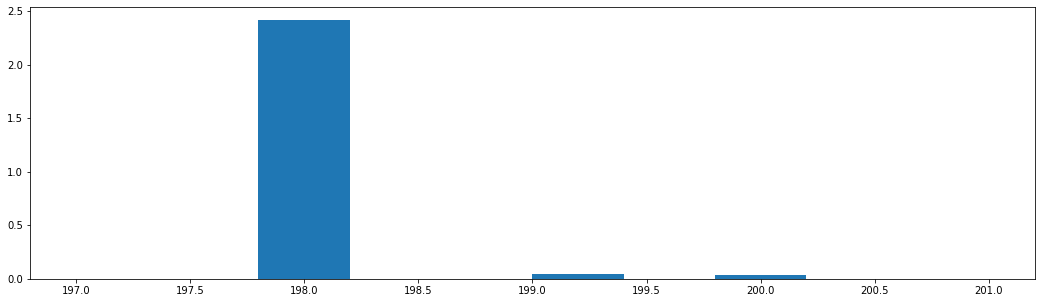

In [0]:
plt.subplots(figsize=(18,5))
plt.hist(tau_samples, density=True)

(array([2.28000e+02, 1.95500e+03, 1.92150e+04, 7.56700e+04, 1.37056e+05,
        1.17656e+05, 4.01850e+04, 7.32300e+03, 6.85000e+02, 2.70000e+01]),
 array([17.36042093, 17.65460445, 17.94878797, 18.24297148, 18.537155  ,
        18.83133852, 19.12552203, 19.41970555, 19.71388907, 20.00807259,
        20.3022561 ]),
 <a list of 10 Patch objects>)

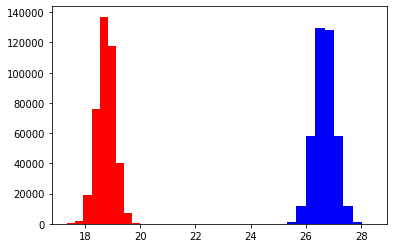

In [0]:
plt.hist(mu_1_samples, color = 'blue')
plt.hist(mu_2_samples, color = 'red')


Los histogramas de ambas distribuciones del primer periodo respecto al segundo periodo no se traslapan, por lo que podemos concluir que el resultado es válido. 